# ImageText

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from nltk.corpus import stopwords
import numpy as np
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
import string
import re
import burst_detection as bd
import warnings
import glob
from itertools import dropwhile
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pickle
import os.path
from collections import defaultdict
import math
from fbprophet import Prophet
import lda
import scipy

from itertools import chain

In [2]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)

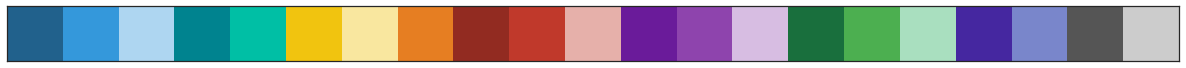

In [3]:
#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

# Functions

In [37]:
#function to extract images stored in a df
def image_extract(x,file_name):
    img_urls = x['image_url']
    dates = x['date']
    for index, (date, url) in enumerate(zip(dates, img_urls)):
        date_x = str(date)[0:10]
        print(date_x)
        try:
            link = urlopen(url)
        except:
            print("Bad URL")
            continue
        try:
            name = "%s_%s_%s.jpg" % (file_name, (index+1), date_x)
            with open(name, "wb") as output:
                output.write(link.read())
        except IOError:
            print("Unable to create %s") % name
            
def doc2ent(string):
    "Shannon entropy for strings (char-level) or tokenized documents (ngram-level)"
    prob = [float(string.count(c))/len(string) for c in dict.fromkeys(list(string))]
    res = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])
    return res

def ent_list(doc_list):
    """ word level entropy for chunked tokenized documents in list """
    res = []
    for d in doc_list:
        tmp = []
        for c in d:
            tmp.append(doc2ent(c))
        res.append(sum(tmp)/float(len(tmp)))
    return res

def renyi_entropy(input, alpha = 2, logbase = 2):
    """
    Renyi entropy for quantifying text diversity/uncertainty/randomness
    - for char and ngram levels
    - alpha = 1 is special case, returns Shannon Entropy
    - not defined for alpha <= 0
    """
    px = [float(input.count(c))/len(input) for c in dict.fromkeys(list(input))]
    if alpha <= 0:
        print('not defined for alpha <= 0')
        return None
    elif alpha == 1:
        return - sum([x*math.log(x,logbase) for x in px])
    else:
        px = [x**alpha for x in px]
        return 1/(1-alpha)* math.log(sum(px),logbase)


def prophet_changepoint_lite(data, n_changepoints=25):
    #data['y'] = np.log(data['y'])
    model = Prophet(n_changepoints=n_changepoints, weekly_seasonality=False)
    model.add_seasonality(name='week_', period=6, fourier_order=3)
    model.fit(data);
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    model.plot_components(forecast)
    figure = model.plot(forecast)
    for changepoint in model.changepoints:
        plt.axvline(changepoint,ls='--', lw=1)
    print(model.changepoints)
    plt.ylabel('number of bursty words')
    plt.xlabel('date')
    plt.savefig('trendline.png', dpi=300, bbox_inches="tight")
    #deltas = model.params['delta'].mean(0)
    #fig = plt.figure(facecolor='w')
    #ax = fig.add_subplot(111)
    #ax.bar(range(len(deltas)), deltas)
    #ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    #ax.set_ylabel('Rate change')
    #ax.set_xlabel('Potential changepoint')
    #fig.tight_layout()
    
def prophet_changepoint(df, data, n_changepoints=25):
    #data['y'] = np.log(data['y'])
    model = Prophet(n_changepoints=n_changepoints, weekly_seasonality=False)
    model.add_seasonality(name='week_', period=6, fourier_order=3)
    model.fit(data);
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    model.plot_components(forecast)
    figure = model.plot(forecast)
    for changepoint in model.changepoints:
        plt.axvline(changepoint,ls='--', lw=1)
    print(model.changepoints)
    deltas = model.params['delta'].mean(0)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    ax.bar(range(len(deltas)), deltas)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_ylabel('Rate change')
    ax.set_xlabel('Potential changepoint')
    fig.tight_layout()
    
    changepoints_index = model.changepoints.index
    changepoints_dates = model.changepoints.values

    n = 20
    for i, delta in zip(changepoints_index, deltas):
    # if change rate is positive show topic model of that date
    # if change is negative show topic model of previous date
        if delta > 0:
            i = i + 1
            print(df.iloc[i].date)
        else:
            print(df.iloc[i].date)
        top_topics = np.argsort(doc_topic[i,:])[::-1][0:5]
        for ii, topic_dist in enumerate(topic_word):
            if ii in top_topics:
                topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
                print('*Topic {}\n- {}'.format(ii, ' '.join(topic_words)))
        print('---'* 20)
    return model, deltas

def KLD(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

#word count function
def freq_dist(data, n_words):
    ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    return freq_distribution.most_common(n_words)

# read write pickles
def write_pickle(name, input_):
    '''
    name specifies where you want to write which file 
    input defines which variable you want to write as a pickle
    '''
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_out = pickle.dumps(input_)
    with open(name, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])
            

def read_pickle(name):
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_in = bytearray(0)
    input_size = os.path.getsize(name)
    with open(name, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    return pickle.loads(bytes_in)

#create dataframe with word proportions
def word_proportions(df, word_list):
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)], axis=1) \
                               .groupby(by=time_frame).sum().reset_index(drop=True)
        if np.mod(i, 100)==0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r

def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2  #resolution of state jumps; lower s --> fewer but stronger bursts
    gam = 0.5 #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d) #number of timepoints
    smooth_win = 5
    
    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])
    
    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)
        
        #find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win)
        
        #enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)
        
        #find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)
        
        #add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)
        
        #print a progress report every 100 words
        if np.mod(i,100)==0:
            print('total words', len(word_list), 'word',i,'complete')
    
    return all_bursts.sort_values(by='weight', ascending=False)

def visualize_bursts(n_bursts, bursts, r, title):
    n = len(d) 
    top_bursts = bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]
    #sort bursts by end date
    sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
    #for burst that end at the last timepoint, sort by start
    last_timepoint = np.max(sorted_bursts['end'])
    sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
    heatmap_data = r.loc[:,set(sorted_bursts['label'])]
    
    #find the baseline proportions sum(r)/sum(d) for each label
    baseline_p = heatmap_data.sum(axis=0) / d.sum()

    #convert r values into proportions at each timepoint
    heatmap_data = heatmap_data.apply(lambda x: x/d)

    #sort the rows according to the order used in the timeline
    order = sorted_bursts['label'].drop_duplicates(keep='last').values
    
    #transpose data and reindex the data according to the sorted word order
    heatmap_data = heatmap_data.T.reindex(order)

    #optional: demean proportions
    #heatmap_data = heatmap_data - heatmap_data.mean(axis=1)

    #optional: convert proportions into multiples of the baseline proportion
    heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

    #smooth proportions with the same smoothing window used in burst detection
    smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

    #create the heatmap
    plt.figure(figsize=(8,30))
    ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
    plt.title('Normalized proportions of top' + title + 'bursting words')
    plt.xticks(range(0,n,24), range(1945,1995,2), rotation='vertical')

    #create boxes around bursting periods
    for index, burst in sorted_bursts.iterrows():
        
        #define outline positions
        y = smoothed_heatmap_data.index.get_loc(burst['label'])
        y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
        xstart = burst['begin'] 
        width = burst['end'] - burst['begin'] + 1
    
        #draw rectangle
        ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))
    plt.savefig(title + "_heatmap.png", bbox_inches="tight", dpi=300)

## PreProcessing

In [ ]:
path = 'data'
allFiles = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))

In [ ]:
stop_word = set(stopwords.words('dutch'))
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
excludes = ['objecttype', 'file directory not found']

#df = df[~df['date'].str.contains('date')] #remove duplicate header rows
#df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
#df['date'] = df['date'].astype('datetime64[ns]') #convert dates 
#df = df.sort_values(by='date') #sort by dates
df['ocr_clean'] = df['ocr'].str.replace(regex_pat, '') #only keep words
df['ocr_clean'] = df['ocr_clean'].str.findall('\w{4,}').str.join(' ') #only keep words more than 3 chars
df['ocr_clean'] = df['ocr_clean'].str.lower().str.strip()
df['ocr_clean'] = df['ocr_clean'].str.strip()#lower and remove whitespaces
df['ocr_clean'] = [' '.join(filter(None,filter(lambda word: word not in stop_word, line))) for line in df['ocr_clean'].str.split(' ')]
df['words'] = df['ocr_clean'].apply(lambda x: x.lower().split())
#calculating proportion of characters relative to size of the advertisement. 
df['area'] = df['w'] * df['h']
df['string_length'] = df['ocr_clean'].str.len()
df['character_proportion'] = df['string_length'] / df ['area']
df = df[df['character_proportion'] < 10] #remove ads with lot of text (i.e. ocr errors)

In [ ]:
df = df[~df['date'].str.contains('date')] #remove duplicate header rows
df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
df['date'] = df['date'].astype('datetime64[ns]') #convert dates 
df['publication_year'] = df['date'].apply(lambda x: x.year)
df['publication_month'] = df['date'].apply(lambda x: x.month)
df['publication_day'] = df['date'].apply(lambda x: x.day)

drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'ocr', 'area']
df.drop(drop_cols, axis=1, inplace=True)

# Read / Write Pickles

In [ ]:
df = read_pickle('ads.pkl')

In [636]:
car_brands = [
    r'\bopel\b',
    r'\brenault\b',
    r'\baudi\b',
    r'\bsimca\b',
    r'\bpeugeot\b',
    r'\bbuick\b',
    r'\bvolkswagen\b',
    r'\bford\b',
    r'\bStandard\b',
    r'\bTriumph\b',
    r'\bfiat\b',
    r'\bnissan\b',
    r'\bBMW\b',
    r'\bmercedes\b',
    r'\bporsche\b',
    r'\bdaewoo\b',
    r'\btoyota\b',
    r'\balfa romeo\b',
    r'\bsubaru\b',
    r'\bhonda\b',
    r'\blexus\b',
    r'\bmazda\b',
    r'\blada\b',
    r'\bhyundai\b',
    r'\bbentley\b',
    r'\bjaguar\b',
    r'\bcadillac\b',
    r'\bchevrolet\b',
    r'\bchrysler\b',
    r'\bjeep\b',
    r'\balfa romeo\b',
    r'\baudi\b'
    r'\bcitroën\b',
    r'\bDAF\b',
    r'\bdaewoo\b',
    r'\bdaihatsu\b',
    r'\blexus\b',
    r'\blancia\b',
    r'\bland rover\b',
    r'\bmercedes-benz\b',
    r'\bmitsubishi\b',
    r'\bopel\b',
    r'\bporsche\b',
    r'\bsaab\b',
    r'\bseat\b',
]

In [637]:
len(car_brands)

44

In [444]:
car_df = df[df['ocr_clean'].str.contains('|'.join(car_brands))]
car_df = car_df[(car_df['w'] > 500) | (car_df['h'] > 500)]
car_df = car_df[car_df['character_proportion'] < 0.00050] #car ads with image and text
car_df['ratio'] = car_df['h'] / car_df['w']
car_df = car_df[car_df['ratio'] < 2]


In [5]:
#car_df.to_pickle('car_14K_ads.pkl')
car_df = pd.read_pickle('ads_image.pkl')

In [6]:
car_df['publication_year'] = car_df['date'].apply(lambda x: x.year)
car_df['publication_month'] = car_df['date'].apply(lambda x: x.month)
car_df['publication_day'] = car_df['date'].apply(lambda x: x.day)
car_df['words'] = car_df['ocr_clean'].apply(lambda x: x.lower().split())

In [7]:
car_df_sample = car_df.sample(frac=.005)
#image_extract(car_df_sample, 'cars')

In [8]:
corpus = np.array(car_df['ocr_clean'])

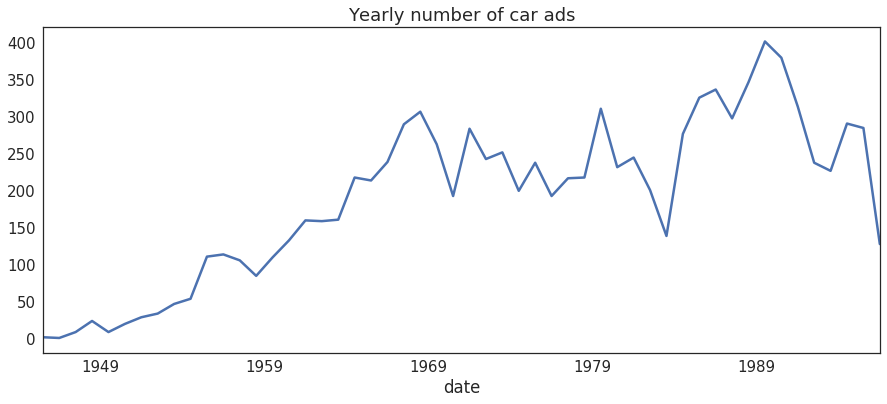

In [9]:
car_df.set_index('date')['ocr_clean'].resample('12M').count().plot(title='Yearly number of car ads')
plt.savefig('yearly_ads.png')

# Unique Words

# LDA TOPIC MODELING

In [9]:
len(car_df)

9863

In [856]:
import lda

#n_features = 10000

K = 100
#also try for K = 100

docs = np.array(car_df['ocr_clean'])

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=None, stop_words=None)
X = tf_vectorizer.fit_transform(docs)
vocab = tf_vectorizer.get_feature_names()

model = lda.LDA(n_topics=K, random_state=1)
model.fit(X)

INFO:lda:n_documents: 13862
INFO:lda:vocab_size: 22756
INFO:lda:n_words: 1254620
INFO:lda:n_topics: 100
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -19125061
INFO:lda:<10> log likelihood: -11828403
INFO:lda:<20> log likelihood: -11069007


KeyboardInterrupt: 

In [539]:
pickle.dump(vocab, open('K_100_vocab.sav', 'wb'))
pickle.dump(model, open('K_100_model.sav', 'wb'))
print("Model Saved!!")

Model Saved!!


In [858]:
with open('K_100_vocab.sav', 'rb') as pickle_file:
    vocab = pickle.load(pickle_file)

with open('K_100_model.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

FileNotFoundError: [Errno 2] No such file or directory: 'K_100_vocab.sav'

In [638]:
topic_word = model.topic_word_
n = 25
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))

*Topic 0
- simca talbot volvo legato dealers alfa audi allegro naam romeo risk autoverhuur volkswagen occasion vier hoofdweg bestel ford chrysler daihatsu austinmorris albatros gewoon bakker mini
*Topic 1
- kmpu prijs nieuwe volkswagen peugeot golf deurs ford extras daily extra fiat motor fijn september chrysler betrouwbaar simca proefrit persoonlijke corolla telefoon zuinig ruim carina
*Topic 2
- mitsubishi jaar gratis vanaf ford peugeot kosten verwijderingsbijdrage daewoo rijklaar fiat alle maken ensembles escort excl mondeo geldt sony incl symfonie modellen uithoorn informatie kunt
*Topic 3
- nieuwe renault gram opel corsa gratis fiat liter tipo autobedrijf ford deurs april automobielbedrijf dealer alfa swing merk panda stuks genoeg prijs neuronorm kilo staat
*Topic 4
- fiat wagen motor nieuwe ford alle prijs grote renault dealer ruimte rijden proefrit telefoon luxe alleen achter wegligging comfort snel elke advertentie nederland kunt waar
*Topic 5
- kleur lease circle fiat nieuwe a

*Topic 42
- austin auto ford jubileum renault nieuwe maestro metro rover extra eigen dealer ohra september onderwijs laser elke kadett escort orion opleiding maand opel zuinig diesel
*Topic 43
- fiat maanden prijs financieren bedrag rente renault vanaf maximum peugeot panda junior alfa merk personenauto mmmm first regata ritmo nieuwe nevada toyota nederland geldt zwarte
*Topic 44
- bravo mini taunus auto metro rover zuinig gratis mazda autos benzine autobedrijf fiesta nationaal avrobode televizier automobielbedrijf range familiespel prijzen prijs ritmo voorbehouden week izgst
*Topic 45
- ohra auto fiat jaar flfl nissan eigen nieuwe honda korting renault austin basispremie risks lancia gratis rente jazz risico ford metallic even maestro rover maken
*Topic 46
- simca autombedr laken auto banden compleet deur automobielbedrijven leder nieuwe hertz avonds wagen schijfremmen showrooms langs maandag telefoon vrijdag cortina stuur autobanden zaterdags bekleding extra
*Topic 47
- jubilee voord

*Topic 84
- liter deurs fiat panda toyota katalysator hatchback rente corolla leverbaar spring renault audi modellen automaat atari peugeot tijdelijk benzine benzinemotor ritmo laagste sedan personenautos eigen
*Topic 85
- auto alle peugeot nederland jaar autos prijs fiat adam mazda volvo renault prijzen opel citroen grote achter kunt mercedes goede deurs nieuw garantie motor alleen
*Topic 86
- astra deurs opel jaar stationwagon ford rood kosten juni alle toyota veetra telefoon peugeot vier blauw zwart stalen volkskrant diesel standaard expression balken young groen
*Topic 87
- nieuwe auto dealer vanaf standaard prijs voorbehouden maken peugeot verstelbare prijzen kunt glas excl elektrisch alleen stuurbekrachtiging getint alfa centrale wijzigingen motor speciale voordeel inclusief
*Topic 88
- fiat jaar opel kosten rijklaar mercedes tempra tipo voorwaarden alle veetra panda krijgt nederland maken komt basic extras fiatdealer corsa huidige astra mitsubishi financiering veiligheidsgordels

In [541]:
topic_word = model.topic_word_

In [544]:
n = 100
topic_words = []
lda_words = []
for i, topic_dist in enumerate(topic_word):
    topic_words.append(np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1])
    for topic in topic_words:
        for word in topic:
            if word not in lda_words:
                lda_words.append(word)

In [641]:
write_pickle(lda_words, 'lda_words.pkl')

TypeError: expected str, bytes or os.PathLike object, not list

In [546]:
doc_topic = model.doc_topic_
print("type(doc_topic): {}".format(type(doc_topic)))
print("shape: {}".format(doc_topic.shape))

type(doc_topic): <class 'numpy.ndarray'>
shape: (13862, 100)


In [463]:
doc_topic_t = doc_topic.T

In [464]:
dates_ = car_df['date']

In [ ]:
f, ax= plt.subplots(16, 1, figsize=(10, 20), sharex=True)

for k in range(0,16):
    ax[k].plot(dates_, doc_topic_t[k])
    #ax[i].set_xlim(-1, 16)
    ax[k].set_ylim(0, 1)
    ax[k].set_ylabel("Prob")
    ax[k].set_title("Topic {}".format(k))

    
plt.tight_layout()
plt.show()

# Detecting Bursts
### Technique from: https://github.com/nmarinsek/burst_analysis/blob/master/fMRIarticle_bursts.ipynb

In [10]:
time_frame = ['publication_year', 'publication_month']
#count the number of articles published each month
d = car_df.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)



In [11]:
all_lda_words = word_proportions(car_df, lda_words)

NameError: name 'lda_words' is not defined

In [ ]:
# burst_lda gamma 0.5, s=2.0
bursts_lda = find_bursts(d, all_lda_words, lda_words)

In [643]:
#all_lda_words.to_pickle('all_lda_words.pkl')
#bursts_lda.to_pickle('bursts_lda.pkl')

In [12]:
# load pickles of words
unique_words = pd.read_pickle('all_unique_words.pkl')
lda_words = pd.read_pickle('all_lda_words.pkl')

# load bursts
bursts_unique = pd.read_pickle('burst_unique.pkl')
bursts_lda = pd.read_pickle('burst_lda.pkl')

In [4]:
bursts_unique

NameError: name 'bursts_unique' is not defined

# Visualize bursts

In [29]:
## Calculate relative burstiness per year

n_bursts = 1000
top_bursts = bursts_unique.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]

n = len(d) 
sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
last_timepoint = np.max(sorted_bursts['end'])

sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)

heatmap_data = unique_words.loc[:,set(sorted_bursts['label'])]
  
baseline_p = heatmap_data.sum(axis=0) / d.sum()
    
#convert r values into proportions at each timepoint
heatmap_data = heatmap_data.apply(lambda x: x/d)


#smooth proportions with the same smoothing window used in burst detection
smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

heatmap_data['total'] = heatmap_data.sum(axis=1)

In [30]:
times = car_df.groupby(['publication_year', 'publication_month'])['words'].count().reset_index()
times['dates'] = pd.to_datetime((times.publication_year*100+times.publication_month).apply(str),format='%Y%m')

In [31]:
heatmap_data['dates'] = times['dates']

In [32]:
#heatmap_data = heatmap_data.set_index('dates')
heatmap_data = heatmap_data.reset_index()

In [33]:
#remove outliers
heatmap_data = heatmap_data[np.abs(heatmap_data['total']-heatmap_data['total'].mean())<=(3*heatmap_data['total'].std())]

In [34]:
x = np.arange(heatmap_data['total'].size) 
fit = np.polyfit(x, heatmap_data['total'], 1)
fit_fn = np.poly1d(fit)

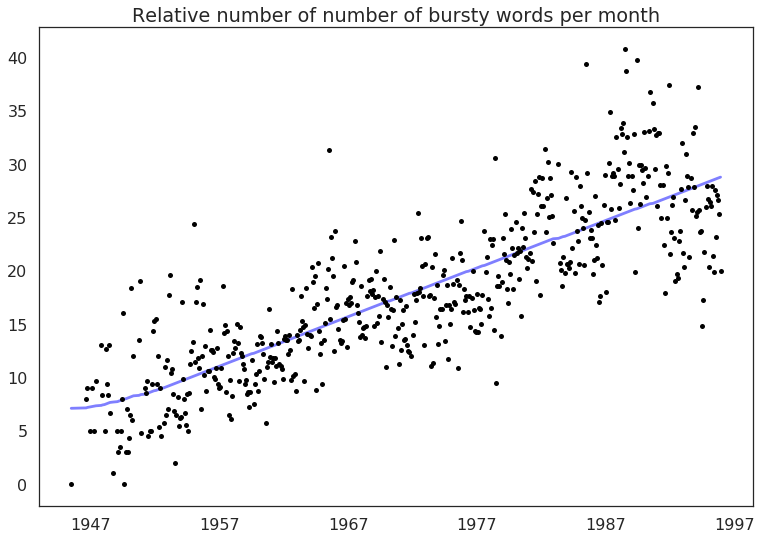

In [35]:
plt.style.use('seaborn-poster')
plt.plot(heatmap_data['dates'], fit_fn(x), 'k-', color='blue', alpha=0.5)
plt.plot(heatmap_data['dates'], heatmap_data['total'], 'go', ms=5, color='black')
plt.title('Relative number of number of bursty words per month')
plt.savefig('bursty-words-permonth.svg')

In [36]:
heatmap_data['y'] = heatmap_data['total']
heatmap_data['ds'] = heatmap_data['dates']

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44    1952-03-01
89    1956-01-01
133   1959-10-01
178   1963-07-01
222   1967-03-01
266   1970-12-01
311   1974-10-01
355   1978-08-01
400   1982-05-01
444   1986-06-01
Name: ds, dtype: datetime64[ns]


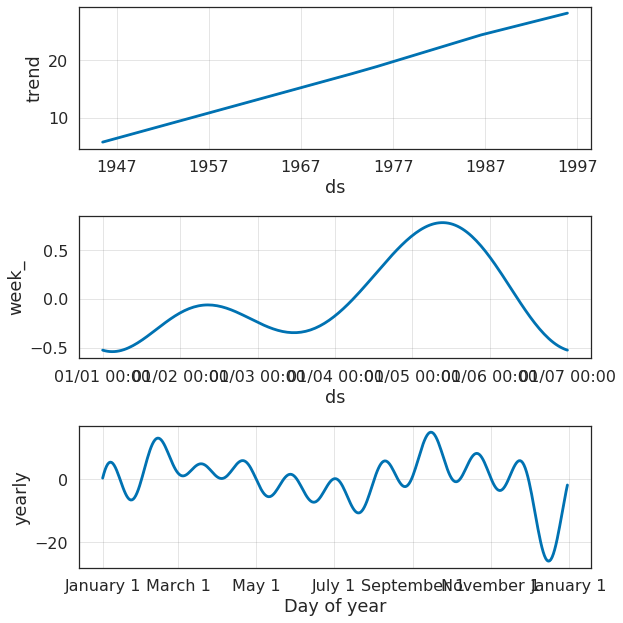

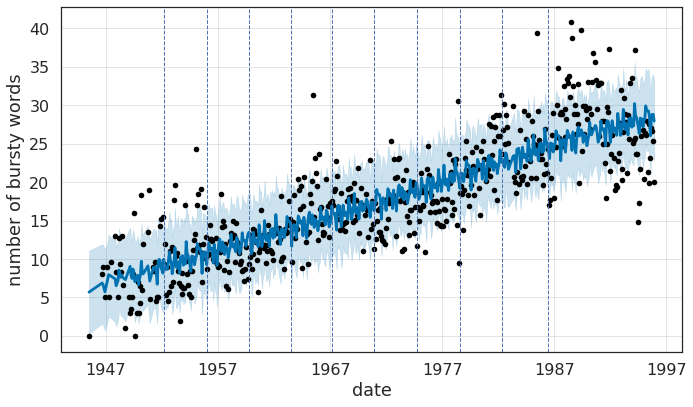

In [38]:
prophet_changepoint_lite(heatmap_data, 10)

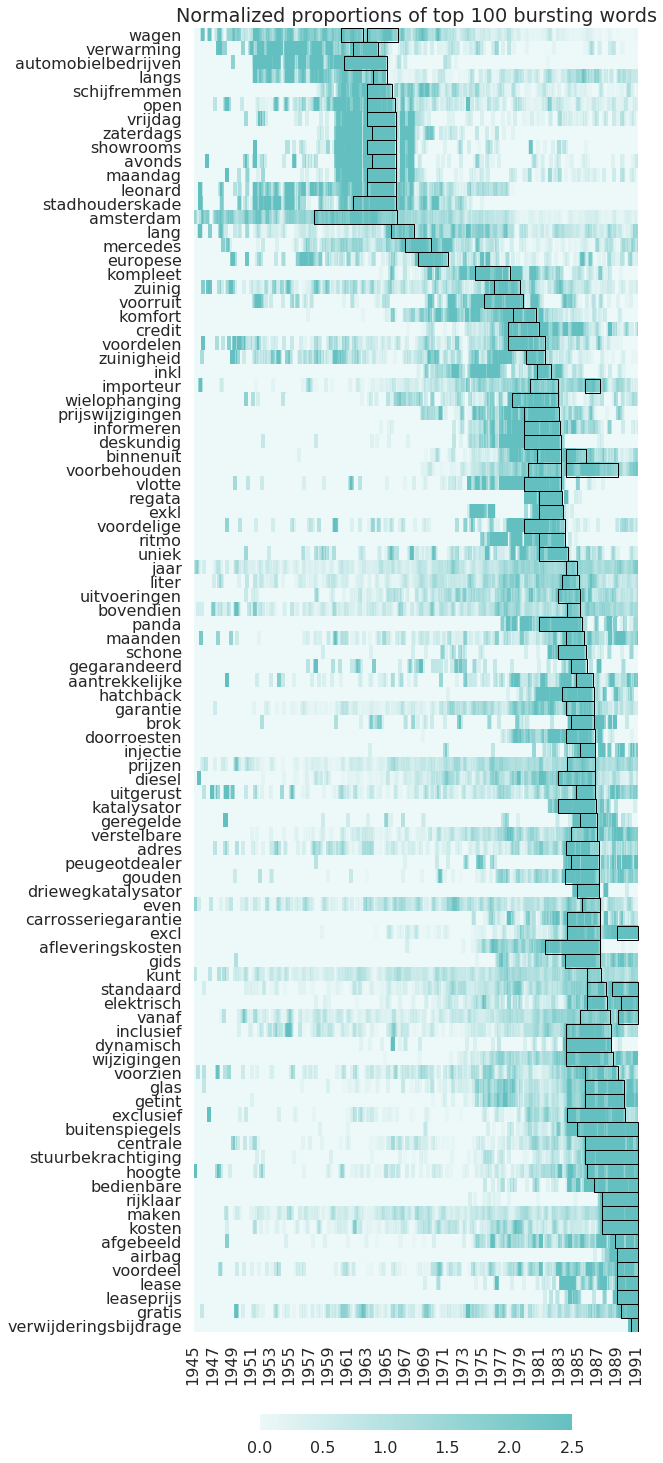

In [39]:
visualize_bursts(100, bursts_unique, unique_words, ' 100 ')


KeyboardInterrupt: 

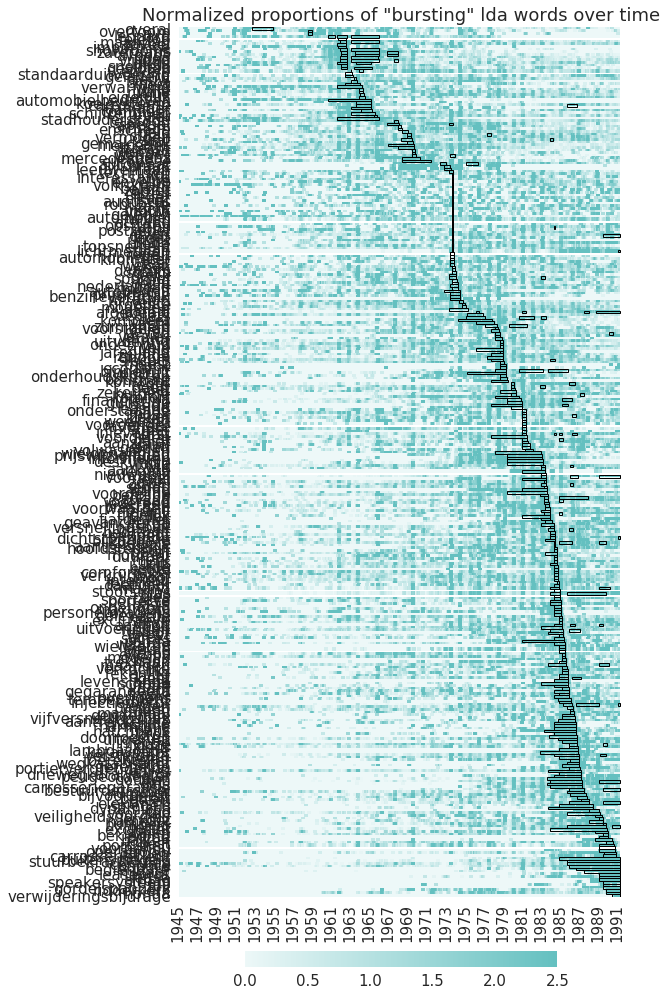

In [19]:
visualize_bursts(500, bursts_lda, lda_words, 'lda')

# KLD

In [29]:
# concatenate all others on front page in one document
#df['text'] = df[['date', 'ocr_clean']].groupby(pd.Grouper(freq='D'))['ocr_clean'].transform(lambda x: ' '.join(x.astype(str)))
car_df['date'] = car_df['date'].astype('datetime64[ns]')
car_df['date'] = pd.to_datetime(car_df.date, format='%Y-%m-%d')   
car_df.index = car_df['date']
car_df['year'] = car_df.date.dt.year

In [152]:
# Merge ads per Month
car_df_week = car_df.copy()
car_df_week['text'] = car_df_week[['date', 'ocr_clean']].groupby(pd.Grouper(freq='D'))['ocr_clean'].transform(lambda x: ' '.join(x))
car_df_week['text'] = car_df_week['text'].drop_duplicates()
car_df_week = car_df_week.dropna()

In [672]:
len(car_df)

13862

In [668]:
#n_features = 10000
stop_words = set(stopwords.words('dutch'))

K = 100

docs = np.array(car_df_week['text'])

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=None, stop_words=stop_words)
X = tf_vectorizer.fit_transform(docs)
vocab = tf_vectorizer.get_feature_names()

model = lda.LDA(n_topics=K, random_state=1234)
model.fit(X)

INFO:lda:n_documents: 13850
INFO:lda:vocab_size: 87895
INFO:lda:n_words: 4093360
INFO:lda:n_topics: 100
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -61974940
INFO:lda:<10> log likelihood: -41386154
INFO:lda:<20> log likelihood: -38563790
INFO:lda:<30> log likelihood: -37603990
INFO:lda:<40> log likelihood: -37069880
INFO:lda:<50> log likelihood: -36728300
INFO:lda:<60> log likelihood: -36477359
INFO:lda:<70> log likelihood: -36273992
INFO:lda:<80> log likelihood: -36121998
INFO:lda:<90> log likelihood: -35997331
INFO:lda:<100> log likelihood: -35896042
INFO:lda:<110> log likelihood: -35811935
INFO:lda:<120> log likelihood: -35734829
INFO:lda:<130> log likelihood: -35668832
INFO:lda:<140> log likelihood: -35611677
INFO:lda:<150> log likelihood: -35558645
INFO:lda:<160> log likelihood: -35511624
INFO:lda:<170> log likelihood: -35478101
INFO:lda:<180> log likelihood: -35441107
INFO:lda:<190> log likelihood: -35406542
INFO:lda:<200> log likelihood: -35375531
INFO:lda:<210> log likel

INFO:lda:<1950> log likelihood: -34994641
INFO:lda:<1960> log likelihood: -34990874
INFO:lda:<1970> log likelihood: -34989280
INFO:lda:<1980> log likelihood: -34989643
INFO:lda:<1990> log likelihood: -34988455
INFO:lda:<1999> log likelihood: -34986960


In [7]:
path = 'models/'

with open(path + 'K_100_vocab.sav', 'rb') as pickle_file:
    vocab = pickle.load(pickle_file)

with open(path + 'K_100_model.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [669]:
pickle.dump(vocab, open('K_100_vocab.sav', 'wb'))
pickle.dump(model, open('K_100_model.sav', 'wb'))
print("Model Saved!!")

Model Saved!!


In [671]:
topic_word = model.topic_word_
#n = 15
#for i, topic_dist in enumerate(topic_word):
#    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
#    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))


doc_topic = model.doc_topic_
print("type(doc_topic): {}".format(type(doc_topic)))
print("shape: {}".format(doc_topic.shape))

type(doc_topic): <class 'numpy.ndarray'>
shape: (13850, 100)


In [673]:
entropies = []
dates = []
for i in range(0, doc_topic.shape[0]):
    dates.append(car_df.iloc[i]['date'])
    entropy = KLD(doc_topic[i], doc_topic[i-1])
    entropies.append(entropy)
df_entropy = pd.DataFrame(list(zip(dates, entropies)),
              columns=['ds','y'])

In [680]:
kld_ = np.zeros(len(doc_topic))    
for i in range(1,len(doc_topic)):
    submat = doc_topic[0:i,]
    tmp = np.zeros(len(submat))
    for ii in range(len(submat)):
        tmp[ii] = KLD(submat[ii,],doc_topic[i,])
    kld_[i] = np.mean(tmp)    
entropies_sum = kld_-np.mean(kld_)

In [685]:
entropy_sum = pd.DataFrame(list(zip(dates, entropies_sum)),
              columns=['ds','y'])

In [189]:
df_entropy = df_entropy.set_index('ds')

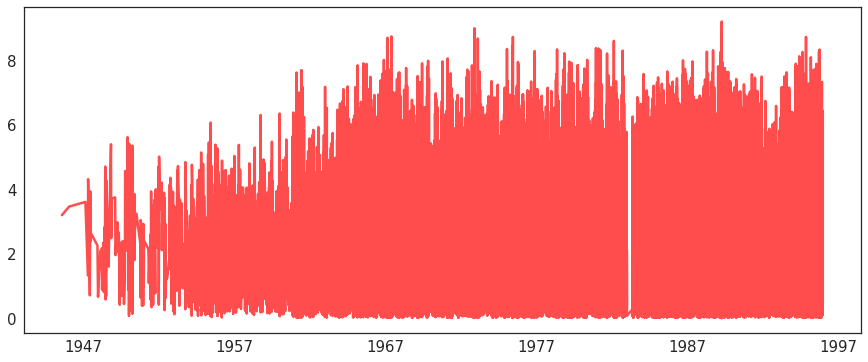

In [675]:
plt.plot(df_entropy['ds'], df_entropy['y'], alpha=0.7, c='red')

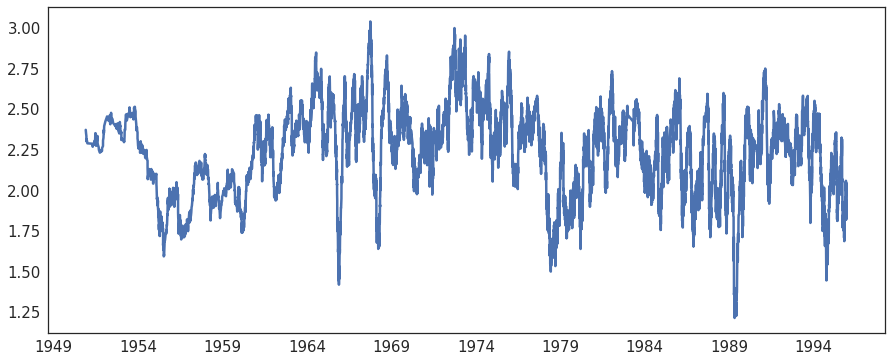

In [687]:
y = df_entropy['y'].rolling(100).mean()
X = df_entropy['ds']

plt.plot(X, y)

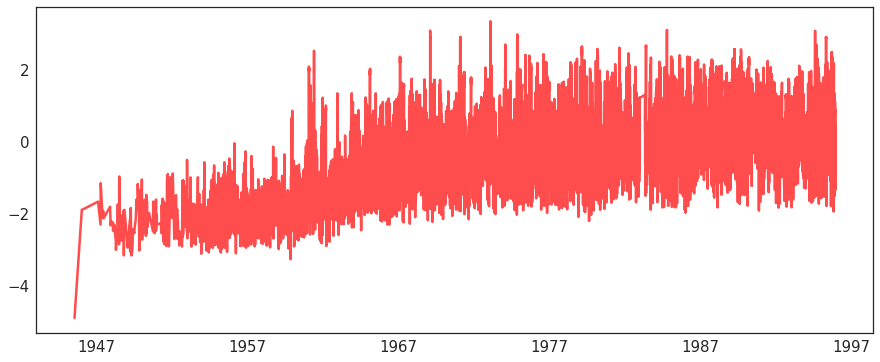

In [686]:
plt.plot(entropy_sum['ds'], entropy_sum['y'], alpha=0.7, c='red')

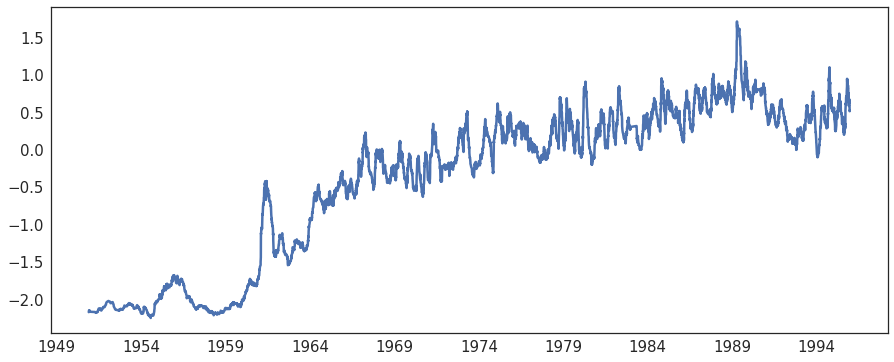

In [688]:
y = entropy_sum['y'].rolling(100).mean()
X = entropy_sum['ds']

plt.plot(X, y)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45    1951-11-01
90    1955-10-01
134   1959-06-01
179   1963-04-01
224   1967-01-01
269   1970-11-01
314   1974-09-01
358   1978-06-01
403   1982-03-01
448   1986-05-01
Name: ds, dtype: datetime64[ns]
1949-06-04 00:00:00
*Topic 29
- morele mensen herbewapening wereld vader leven simca geven waar onze advertentie tussen generaal strijd land nauwelijks mercedes werk brazili staat
*Topic 34
- fiat prijs nieuwe zaterdag advertentie porsche meubel turnhout renault auto bouwj opel open master jaar zondag lang europa first enig
*Topic 51
- opel kadett motors opeldealer rekord general prijs ascona corsa diesel deurs auto nederland inclusief vanaf exclusief speciale extras rotterdam afleveringskosten
*Topic 73
- mitsubishi galant lancer auto sassenheim nieuwe colt gouden gids hart jaar vanaf greeve prijs voorbehouden dealeradressen diesel dealer nibbrig perfektie
*Topic 83
- model motor mercedesbenz alle grote compleet adam prijs keuze montage goed cash auto modellen ford nieuw vanaf meter car

*Topic 22
- ford amsterdam wagen nieuwe telefoon automobielbedrijf dealer garage official opel chevrolet alle automobiel lijn haag modellen dealers nederland auto luxe
*Topic 26
- autom garage bekleding bedrijf motor fiat peugeot alle audi nefkens achter dinpk portieren wielen liter onafhankelijk grote bagageruimte geveerd wagen
*Topic 65
- auto onze kunt jaar nieuwe alleen waar goed alle even gaan weer komt gaat natuurlijk autos mensen eerste rijden staat
*Topic 93
- renault motor wagen comfort auto prijs amsterdam ruimte vier grote dauphine wielen snelheid schijfremmen nieuwe proefrit open alle gesloten major
------------------------------------------------------------


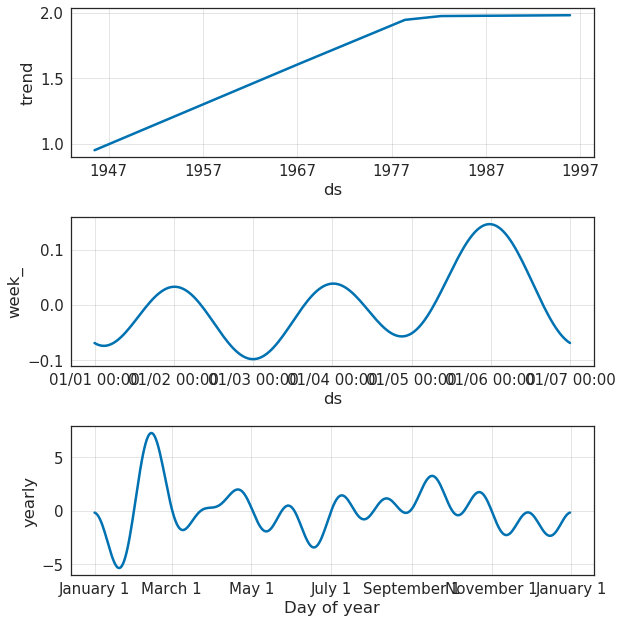

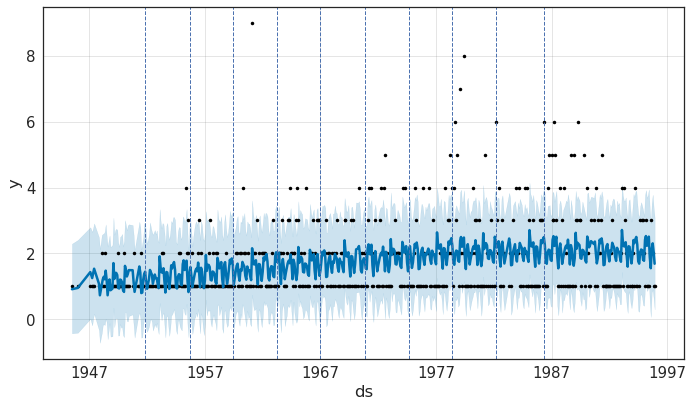

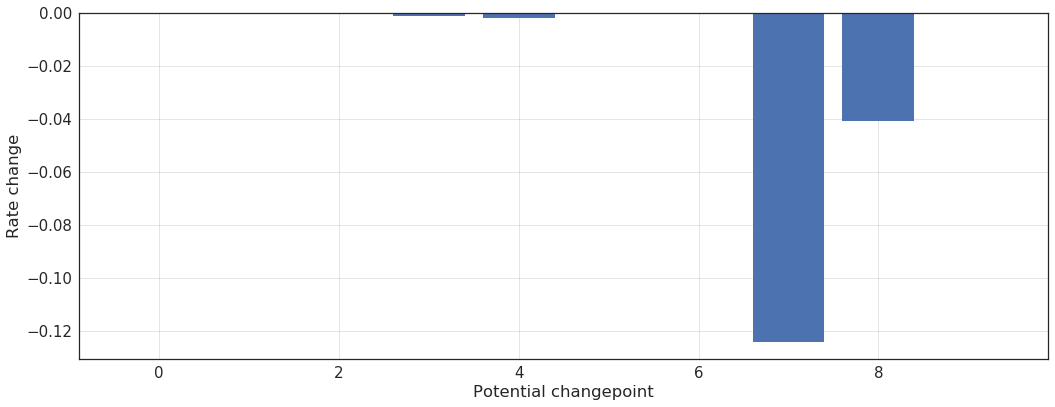

In [724]:
model_, deltas = prophet_changepoint(car_df, times, 10)

In [ ]:
# resampling time series
df_entropy = df_entropy.set_index('ds').resample('M').apply(np.mean)
df_entropy.index = df_entropy.index - pd.offsets.MonthBegin(1) #return beginning of month
df_entropy.reset_index(inplace=True)

In [150]:
car_df.shape[0]

13862

In [10]:
time_range = [1, 7]

In [56]:
doc_topic[5

array([ 0.00705128,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00705128,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00705128,  0.02628205,  0.00064103,  0.00705128,  0.00064103,
        0.00064103,  0.06474359,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.05192308,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.01346154,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00705128,  0.00705128,  0.00064103,
        0.00705128,  0.00064103,  0.00064103,  0.00064103,  0.00064103,
        0.00064103,  0.00064103,  0.00064103,  0.00064103,  0.00

In [689]:
entropies = []
dates = []
for i in range(7, doc_topic.shape[0] - 7):
    dates.append(car_df_week.iloc[i]['date'])
    time_range = range(-7 , 7)
    w = (len(time_range))
    KLDs = []
    for d in time_range:
        KLDs.append(KLD(doc_topic[i], doc_topic[i + d]))
    avg_KLD = 1/w * np.sum(KLDs)
    entropies.append(avg_KLD)
df_entropy_week = pd.DataFrame(list(zip(dates, entropies)),
              columns=['ds','y'])

In [690]:
df_entropy_week = df_entropy_week.set_index('ds')

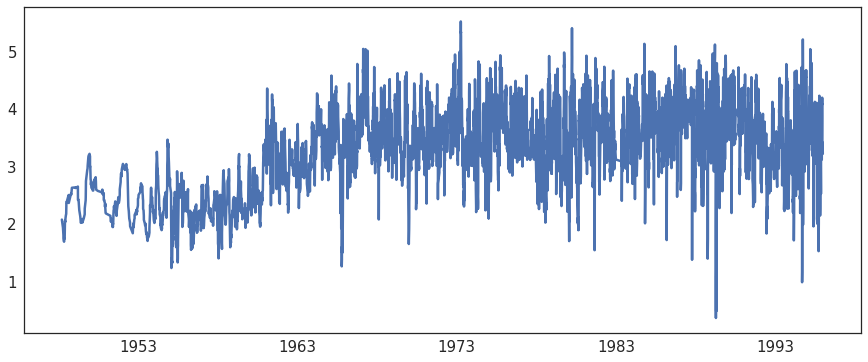

In [693]:
y = df_entropy_week['y'].rolling(10).mean()
X = df_entropy_week.index

plt.plot(X, y)

In [773]:
jump_entropies_ = []
baseline_entropies_ = []
dates = []
jump_size = []

#jumps = chain(range(30, 360, 7), range(361, 540, 14), range(540,1000, 30))


for jump in range(30, 1000, 10):
    print("jump size: {}".format(jump))
    for i in range(jump, doc_topic.shape[0] - jump):
    #for i in range(jump, 2000 - jump):
        dates.append(car_df_week.iloc[i]['date'])
        jump_size.append(jump)
        time_range = range(-7, 7)
        w = (len(time_range))
        jump_entropies = []
        baseline_entropies = []
        for d in time_range:
            baseline_entropies.append(KLD(doc_topic[i], doc_topic[i+d]))
            jump_entropies.append(KLD(doc_topic[i + d], doc_topic[(i - jump) + d]))
        avg_jump_entropies = 1/w * np.sum(jump_entropies)
        avg_baseline_entropies = 1/w * np.sum(baseline_entropies)
        baseline_entropies_.append(avg_baseline_entropies)
        jump_entropies_.append(avg_jump_entropies)
    difference = [a - b for a, b in zip(jump_entropies_, baseline_entropies_)]
    difference = np.array(difference)
    df_kld = pd.DataFrame(list(zip(dates, baseline_entropies_ ,jump_entropies_, difference)),
              columns=['dates', 'baseline_entropies', 'jump_entropies_', 'difference'])
    df_kld['jump_size'] = jump_size 

jump size: 30
jump size: 40
jump size: 50
jump size: 60
jump size: 70
jump size: 80
jump size: 90
jump size: 100
jump size: 110
jump size: 120
jump size: 130
jump size: 140
jump size: 150
jump size: 160
jump size: 170
jump size: 180
jump size: 190
jump size: 200
jump size: 210
jump size: 220
jump size: 230
jump size: 240
jump size: 250
jump size: 260
jump size: 270
jump size: 280
jump size: 290
jump size: 300
jump size: 310
jump size: 320
jump size: 330
jump size: 340
jump size: 350
jump size: 360
jump size: 370
jump size: 380
jump size: 390
jump size: 400
jump size: 410
jump size: 420
jump size: 430
jump size: 440
jump size: 450
jump size: 460
jump size: 470
jump size: 480
jump size: 490
jump size: 500
jump size: 510
jump size: 520
jump size: 530
jump size: 540
jump size: 550
jump size: 560
jump size: 570
jump size: 580
jump size: 590
jump size: 600
jump size: 610
jump size: 620
jump size: 630
jump size: 640
jump size: 650
jump size: 660
jump size: 670
jump size: 680
jump size: 690
ju

In [774]:
df_kld = df_kld.set_index('dates')

In [775]:
idx = df_kld.groupby(['dates'])['difference'].transform(min) == df_kld['difference']
df_kld2 = df_kld[idx]

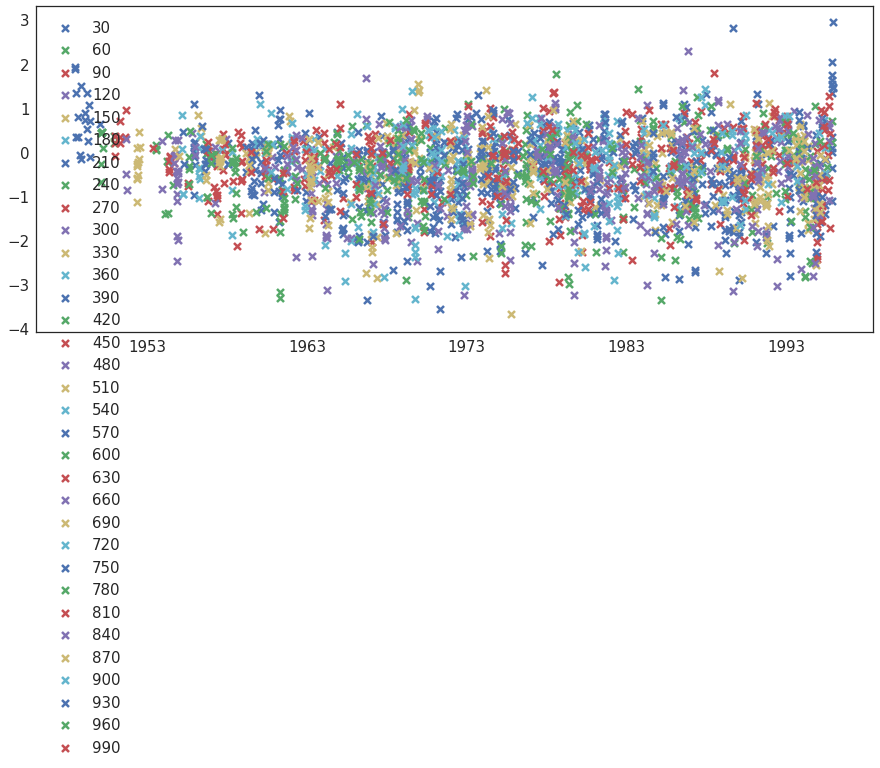

In [776]:
for jump in range(30, 1000, 30):
    y = df_kld2['difference'][df_kld2['jump_size'] == jump]
    x = df_kld2.index[df_kld2['jump_size'] == jump]
    plt.scatter(x, y, label=jump, marker='x')
    plt.legend()

In [706]:
x 

,baseline_entropies,jump_entropies_,difference,jump_size
dates,,,,
1948-06-26,2.125194,4.038742,1.913548,30
1948-07-03,2.057251,3.928298,1.871047,30
1948-07-08,3.621505,3.959495,0.337990,30
1948-07-12,2.292502,3.620714,1.328211,30
1948-08-28,3.101628,3.444250,0.342623,30
1948-08-31,2.596499,3.395337,0.798838,30
1948-10-21,3.407158,3.342780,-0.064378,30
1948-10-27,1.732301,3.235700,1.503399,30
1948-11-11,3.239672,3.069773,-0.169900,30


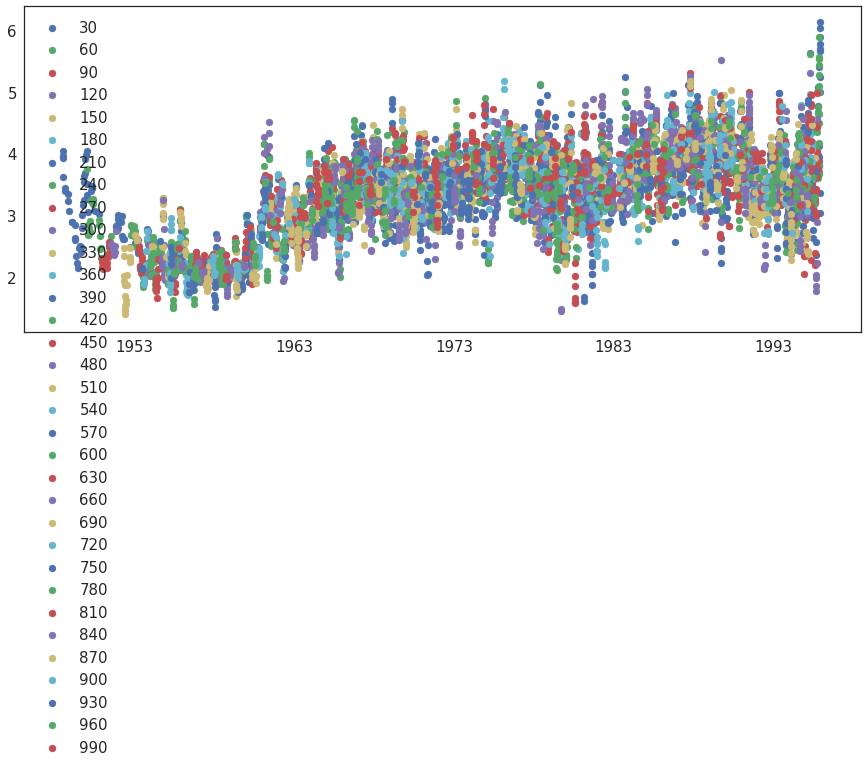

In [705]:
for jump in range(30, 1000, 30):
    y = df_kld2['jump_entropies_'][df_kld2['jump_size'] == jump]
    x = df_kld2.index[df_kld2['jump_size'] == jump]
    plt.scatter(x, y, label=jump)
    plt.legend()

<Container object of 3 artists>

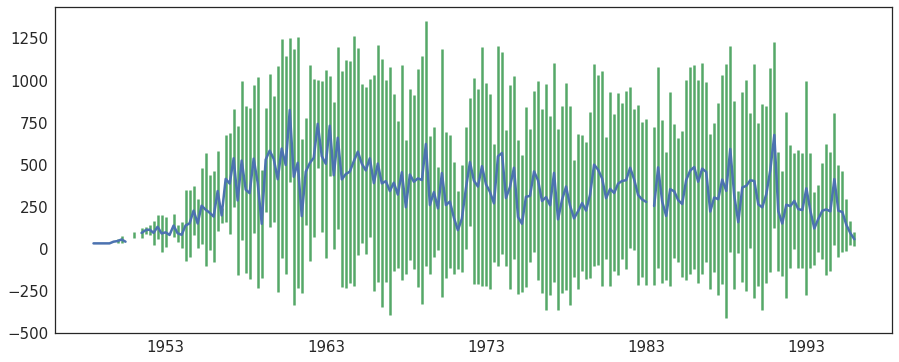

In [777]:
mean = df_kld2['jump_size'].groupby(pd.TimeGrouper('3M')).mean()
std = df_kld2['jump_size'].groupby(pd.TimeGrouper('3M')).std()
plt.plot(mean)
plt.errorbar(mean.index, mean, yerr=2*std, linestyle='')

In [762]:
std

dates
1948-06-30   NaN        
1948-12-31    0.000000  
1949-06-30    0.000000  
1949-12-31    7.745967  
1950-06-30    15.269321 
1950-12-31    18.647447 
1951-06-30    15.000000 
1951-12-31    41.120665 
1952-06-30    59.111062 
1952-12-31    44.333296 
1953-06-30    49.893976 
1953-12-31    63.108005 
1954-06-30    97.315582 
1954-12-31    84.200483 
1955-06-30    136.905928
1955-12-31    119.458364
1956-06-30    104.777016
1956-12-31    162.028366
1957-06-30    222.508352
1957-12-31    226.060526
1958-06-30    269.304175
1958-12-31    284.068938
1959-06-30    278.462197
1959-12-31    264.440735
1960-06-30    291.197941
1960-12-31    357.531196
1961-06-30    303.070857
1961-12-31    220.055255
1962-06-30    247.860488
1962-12-31    282.791560
                 ...    
1981-06-30    258.205375
1981-12-31    225.614479
1982-06-30    285.366023
1982-12-31    293.152198
1983-06-30    301.792772
1983-12-31    309.301477
1984-06-30    210.238516
1984-12-31    172.777989
1985-06-30    313.8

In [734]:
df_kld2 = df_kld2.set_index('dates')
x = df_kld2.index
y = df_kld2['jump_size']

plt.scatter(x, y, marker='o')
plt.legend()

KeyError: 'dates'

In [714]:
import statsmodels.formula.api as sm

In [719]:
df_kld2 = df_kld2.reset_index()

KeyboardInterrupt: 

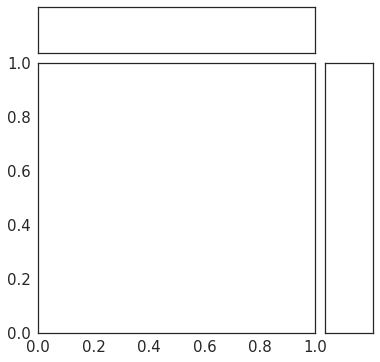

In [725]:
g = sns.jointplot(dates, jump_size, data=df_kld2, kind='reg')

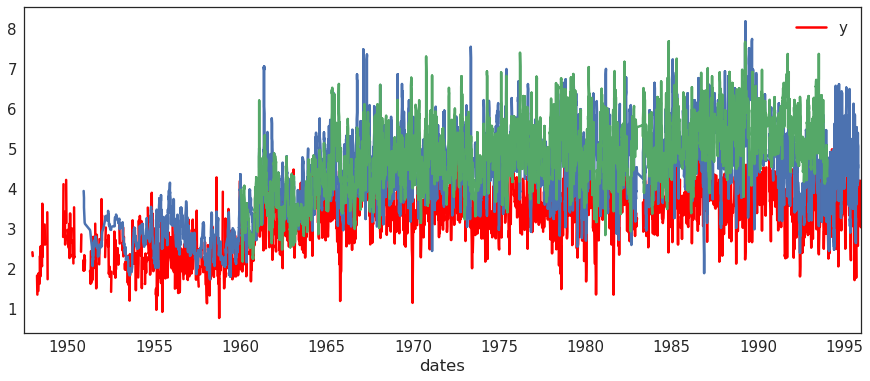

In [417]:
df_entropy.resample('W').plot(color='r')
df_kld['KLD_diff'][df_kld['jump_size'] == 100].plot()
df_kld['KLD_diff'][df_kld['jump_size'] == 1000].plot()

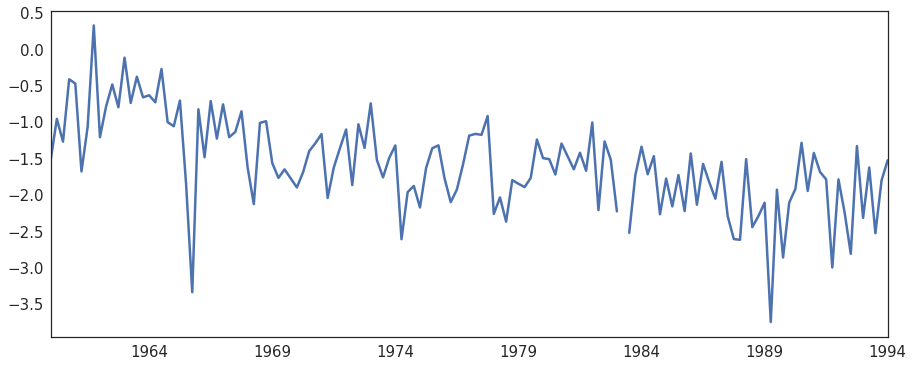

In [215]:
diff_.resample('3M').plot()

In [798]:
def calculate(dataframe):
    dates = []
    novelty = []
    transience = []
    resonance = []
    time_frame = []
    for w in range(1, 52, 1):
        print(w)
        for i in range(w, doc_topic.shape[0] - w ):
            time_frame.append(w)
            avg_transience = 0
            avg_novelty = 0
            dates.append(dataframe.iloc[i]['date'])
            novelties = []
            transiences = []
            for d in range(1, w+1):
                novelties.append(KLD(doc_topic[i], doc_topic[i-d]))
                transiences.append(KLD(doc_topic[i], doc_topic[i+d]))
            avg_novelty = 1/w * np.sum(novelties)
            avg_transience = 1/w * np.sum(transiences)
            transience.append(avg_transience)
            novelty.append(avg_novelty)
        resonance = [a - b for a, b in zip(novelty, transience)]
        resonance = np.array(resonance)
            
    df_kld = pd.DataFrame(list(zip(transience, novelty, resonance)),
              columns=['transience','novelty', 'resonance'])
    df_kld['time_frame'] = time_frame
    df_kld['dates'] = dates
    df_kld.to_pickle('df_kld_final.pkl')
    return df_kld

In [799]:
df_kld = calculate(car_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


In [ ]:
df_kld.to_pickle('df_kld_k_50_final.pkl')
#df_kld = pd.read_pickle('df_kld_k_50_final.pkl')

In [800]:
df_kld.reset_index(inplace=True)

In [801]:
df_kld['year'] = df_kld.dates.dt.year

In [802]:
from scipy.stats import zscore
numeric_cols = ['transience', 'novelty', 'resonance']
df_kld[['transience-z', 'novelty-z', 'resonance-z']] = df_kld[numeric_cols].apply(zscore)
df_kld = df_kld.set_index('dates')

In [803]:
df_kld_2 = pd.melt(df_kld, id_vars=['time_frame'], value_vars=['transience', 'novelty'])

In [804]:
mask = df_kld_2['variable'] == 'transience'
df_kld_2.loc[mask, 'time_frame'] = df_kld_2.loc[mask, 'time_frame'] * -1



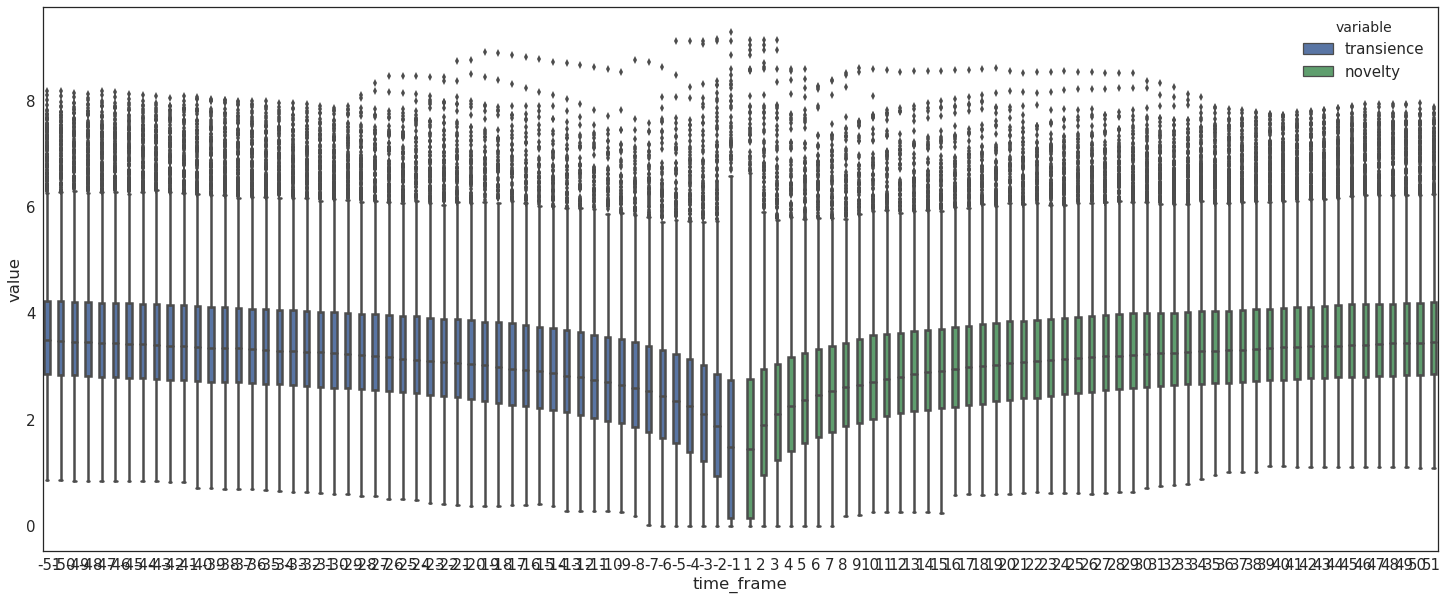

In [805]:
fig = plt.figure(figsize=(25,10))
ax = sns.boxplot(x="time_frame", y="value", hue='variable', data=df_kld_2, linewidth=2.5)

In [806]:
novelties = []
for w in time_range:
    novelties.append(df_kld['novelty'][df_kld['time_frame'] == w].resample('M').apply(np.sum))


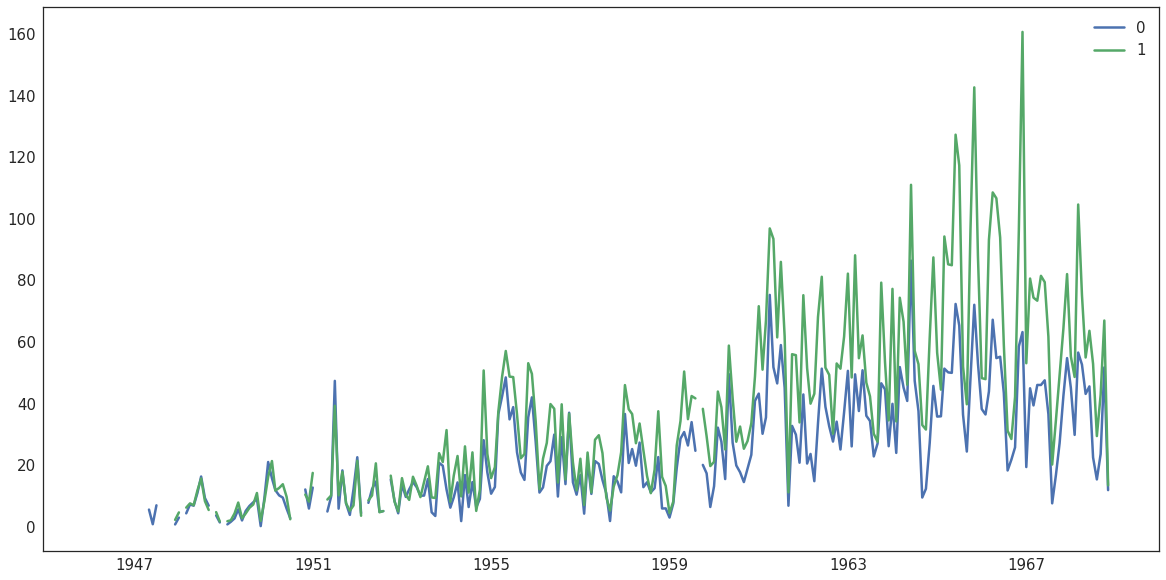

In [808]:
plt.figure(figsize=(20,10))
for i, novelty in enumerate(novelties):
    plt.plot(novelty, label=i)
    plt.legend()

Decreased differences between lines on all time-scales suggest that innovation breaks with all tradition, long or short. Also differences in novelty decrease with time scale. 

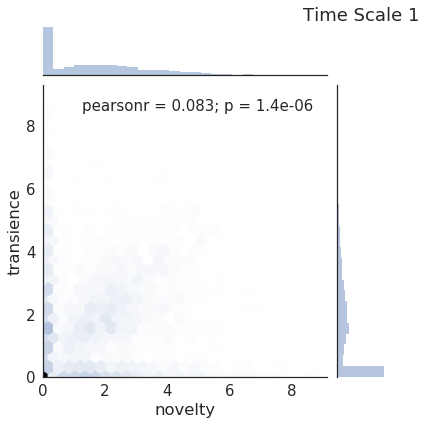

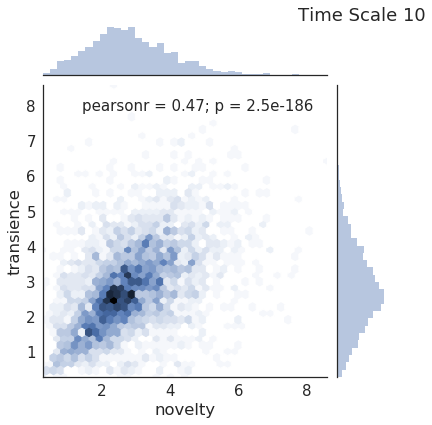

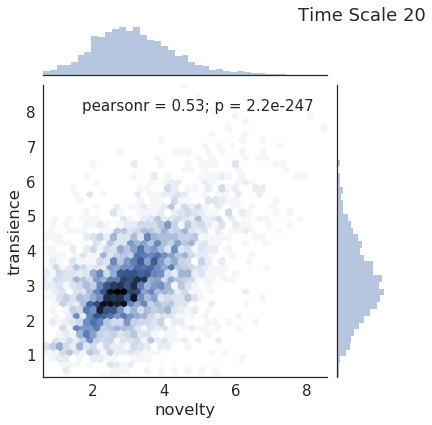

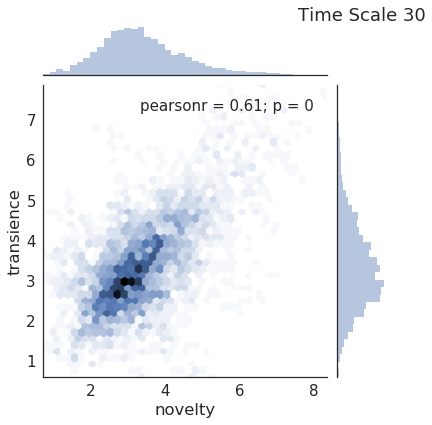

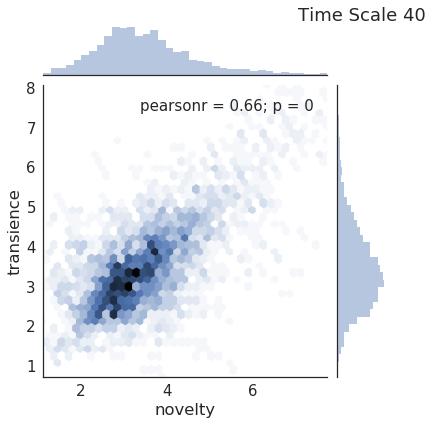

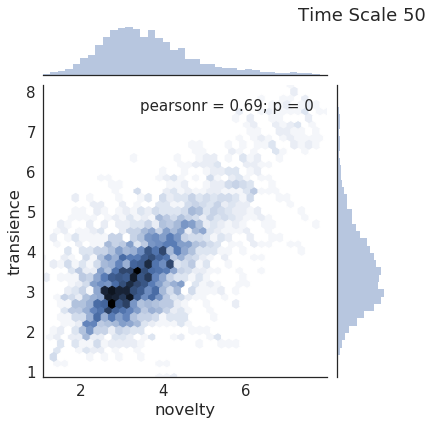

In [810]:
import seaborn as sns
time_range = [1, 10, 20, 30, 40, 50]
for w in time_range:
    novelty = df_kld['novelty'][df_kld['time_frame'] == w]
    transience = df_kld['transience'][df_kld['time_frame'] == w]
    #g = sns.jointplot(novelty, transience, kind='hex', xlim=[-7,7], ylim=[-7,7])
    g = sns.jointplot(novelty, transience, kind='hex')
    #plt.plot(range(0, 10), range(0,10))
    plt.title('Time Scale {}'.format(w), y=1.20)

Speeches close to symmetry line are symmetric in suprise from past and from the future. 
The trend line goes up meaning that speeches that are innovative compared to speeches from before are more likely to be transient. 

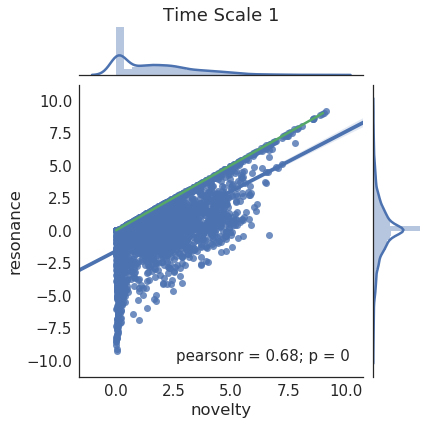

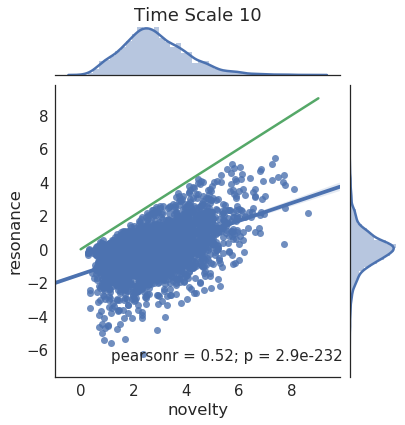

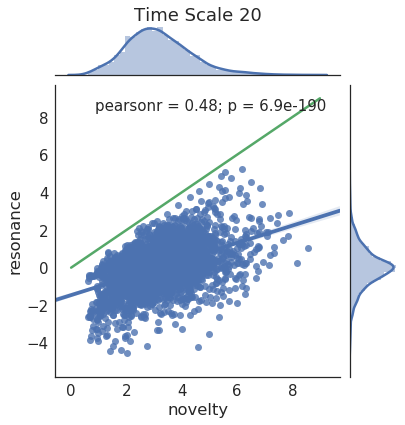

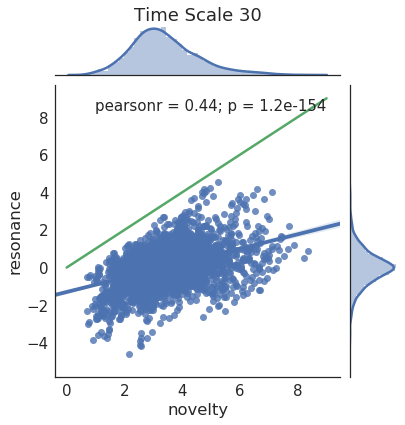

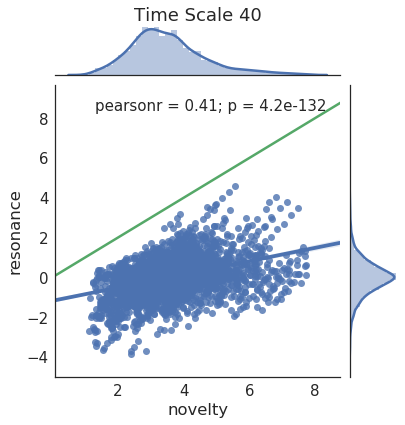

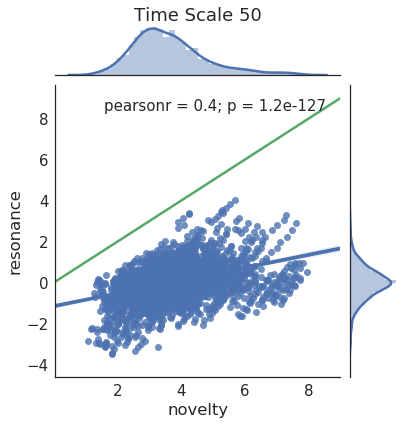

In [811]:
'''
Resonance, the quality of at once breaking from the past and influencing the future
'''

import seaborn as sns
for w in time_range:
    novelty = df_kld['novelty'][df_kld['time_frame'] == w]
    resonance = df_kld['resonance'][df_kld['time_frame'] == w]
    #g = sns.jointplot(novelty, transience, kind='hex', xlim=[-7,7], ylim=[-7,7])
    ax = sns.jointplot(novelty, resonance, kind="reg")
    plt.plot(range(0, 10), range(0,10))
    plt.title('Time Scale {}'.format(w), y=1.20)

In [ ]:
import statsmodels.formula.api as sm

maximizing resonance > the power to influence conversation > expected resonance of speech. Novelty effectiviness Gamma.

In [812]:
gammas = []
intercepts = []
w_s = []
for w in time_range:
    try:
        result = sm.ols(formula="resonance ~ novelty", data=df_kld[df_kld['time_frame'] == w]).fit()
        gamma = result.params[1]
        intercept = result.params[0]
        gammas.append(gamma)
        w_s.append(w)
        intercepts.append(intercept)
    except:
        pass
gamma_df = pd.DataFrame(list(zip(w_s, intercepts, gammas)),
                        columns=['scales', 'intercept', 'gamma'])

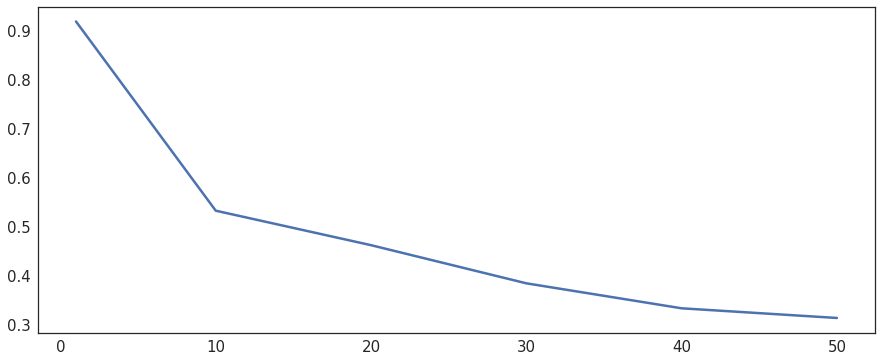

In [814]:
X = gamma_df['scales']
y = gamma_df['gamma']
plt.plot(X, y)

In [ ]:
y

In [ ]:
df_kld

In [815]:
mean_novelties = {}
mean_resonance = {}
mean_transience = {}
for w in df_kld['time_frame']:
    mean_novelties[w] = df_kld['novelty'][df_kld['time_frame'] == w].mean()
    mean_transience[w] = df_kld['transience'][df_kld['time_frame'] == w].mean()
    mean_resonance[w] = df_kld['resonance'][df_kld['time_frame'] == w].mean()

KeyboardInterrupt: 

In [ ]:
scales = list(mean_resonance.keys())           
values = list(mean_resonance.values())        
plt.plot(scales, values)


## Bayesian Change Point Detection

In [ ]:
import cProfile
import sselogsumexp

In [ ]:
data = df_entropy['y']
dates_ = df_entropy['ds']

In [ ]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

In [ ]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

In [ ]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial

R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(dates_, data)
ax = fig.add_subplot(3, 1, 2)
sparsity = 5  # only plot every fifth data for faster display
#ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
#          np.array(range(0, len(R[:,0]), sparsity)), 
#          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
#          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

In [ ]:
plt.plot(R[Nw,Nw:-1])

## Gensim Topic Modeling

In [ ]:
from nltk import word_tokenize
from gensim import corpora
from gensim import models
from gensim.models import LdaModel, LdaMulticore
from multiprocessing import cpu_count
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
docs = np.array(car_df['ocr_clean'])
docs = [document.split() for document in docs]

dictionary = Dictionary(docs)
#dictionary.filter_extremes(no_below=10, no_above=.1) #very strict pruning similar to tf-idf pruning
dictionary.filter_extremes(no_below=5, no_above=.95)
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [ ]:
# Set training parameters.
num_topics = 16
#chunksize = 2000
passes = 20
eval_every = 5  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token


%time model = LdaModel(corpus=corpus, id2word=dictionary, alpha='auto', eta='auto', num_topics=num_topics,passes=passes, eval_every=eval_every, random_state=999)
#%time model = LdaMulticore(corpus=corpus, id2word=id2word, eta='auto', workers=cpu_count()-1, iterations=iterations, num_topics=num_topics,passes=passes, eval_every=eval_every)

In [ ]:
model = LdaModel.load('lda-k16.model')

In [ ]:
'''
Extract the top 150 words each topic and put the 150 unique words in a list
'''

topic_words = []
lda_words = []
for i in range(num_topics):
    tt = model.get_topic_terms(i,150)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    for topic in topic_words:
        for word in topic:
            if word not in lda_words:
                lda_words.append(word)

In [ ]:
len(lda_words)

In [ ]:
all_topics = []
topics = model.get_document_topics(corpus, per_word_topics=True)
all_topics = [max(doc_topics[0], key=lambda item:item[1]) for doc_topics in topics]
topic_list = []
for topic in all_topics:
    topic_x = topic[0]
    topic_list.append(topic_x)
car_df['all_topics'] = all_topics
car_df['topic'] = topic_list

In [ ]:
car_df.to_pickle('car_df_topics.pkl')

In [ ]:
#car_df = pd.read_pickle('car_df_topics.pkl')

## Evaluation topic models

In [ ]:
def evaluate_graph(dictionary, corpus, texts, begin, end, steps):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    """
    u_mass = []
    c_v = []
    lm_list = []
    for num_topics in range(begin, end, steps):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='auto', iterations=500, passes=20)
        #lm = LdaMulticore(corpus=corpus, id2word=id2word, eta='auto', workers=3, iterations=500, num_topics=num_topics,passes=passes, eval_every=None)
        lm_list.append(lm)
        cm_umass = CoherenceModel(model=lm, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        cm_cv = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm_cv.get_coherence())
        u_mass.append(cm_umass.get_coherence())
        
    # Show graph
    x = range(begin, end, steps)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    # Show graph
    x = range(begin, end, steps)
    plt.plot(x, u_mass)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("u_mass"), loc='best')
    plt.show()
    
    return lm_list

In [ ]:
c_v = evaluate_graph(dictionary, corpus, docs, 5, 100, 1)

In [ ]:
lm_list

In [ ]:
c_v = []
with open('c_v.txt') as inputfile:
    for line in inputfile:
        c_v.append(line.strip().split(','))

# Show graph
    x = range(5, 100, 1)
    plt.xticks(np.arange(min(x), max(x)+5, 5.0))
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    plt.savefig('c_v.png')

u_mass = []
with open('u_mass.txt') as inputfile:
    for line in inputfile:
        u_mass.append(line.strip().split(','))

# Show graph
    x = range(5, 100, 1)
    plt.plot(x, u_mass)
    plt.xlabel("num_topics")
    plt.ylabel("u_mass")
    plt.legend(("u_mass"), loc='best')
    plt.show()

In [ ]:
u_mass[11]

In [ ]:
c_v[11]

In [ ]:
top_topics = model.top_topics(corpus, topn=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
cm = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
cm_cv = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
print(cm.get_coherence())
print(cm_cv.get_coherence())

In [ ]:
car_df